In [1]:
#from __future__ import unicode_literals, absolute_import, generators, \
#    print_function

import requests
from datetime import datetime, timedelta
import numpy as np
import time
import pandas as pd




import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from selenium import webdriver
from selenium.webdriver.common.desired_capabilities import DesiredCapabilities
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

from bs4 import BeautifulSoup

import locale
import re
from urllib.parse import urlencode


locale.setlocale(locale.LC_TIME, str('de_DE'))   #necessary for airfinder



'de_DE'

In [2]:
class SkyPickerApi(object):
    """ SkyPicker API. """
    def __init__(self):
        """ Initializes the API object with URL attributes. """
        self.base_url = 'https://api.skypicker.com/'
        self.path = ''
        self.param_str = ''

    @property
    def full_url(self):
        """ Returns the full URL for requesting the data. """
        return '{}{}{}'.format(self.base_url, self.path, self.param_str)

    def get_request(self):
        """ Requests the API endpoint and returns the response """
        headers = {'content-type': 'application/json'}
        resp = requests.get(self.full_url, headers=headers)
        return resp.json()

    def search_places(self, place_name, locale=None):
        """ Finds matching place API ids to use for searches.
        :param place_name: string of the place name to search for
        :kwarg locale: two letter lowercase locale string

        returns JSON response
        """
        self.path = 'places'
        self.param_str = '?term={}'.format(place_name)
        if locale:
            self.param_str += '&locale={}'.format(locale)
        return self.get_request()

    def search_flights(self, origin, destination, start_date, end_date,
                       num_passengers):
        """ Searches for flights given a time range and origin and destination.
        :param origin: string representing the ID or IATA
        :param destination: string representing the ID or IATA
        :param start_date: datetime representing first possible travel date
        :param end_date: datetime representing last possible travel date
        :param num_passengers: integer

        returns JSON response
        """
        self.path = 'flights'
        self.param_str = '?flyFrom=' + \
            '{}&to={}&dateFrom={}&dateTo={}&passengers={}&curr={}&partner=picky'.format(
                origin, destination, start_date.strftime('%d/%m/%Y'),
                end_date.strftime('%d/%m/%Y'), num_passengers,'USD')
        resp = self.get_request()
        flights = []
        for flight in resp.get('data'):
            flight_info = {
                'departure': datetime.utcfromtimestamp(flight.get('dTimeUTC')),
                'arrival': datetime.utcfromtimestamp(flight.get('aTimeUTC')),
                'price': flight.get('price'),
                'currency': resp.get('currency'),
                'legs': []
            }
            flight_info['duration'] = flight_info['arrival'] - \
                flight_info['departure']
            flight_info['duration_hours'] = (flight_info[
                'duration'].total_seconds() / 60.0) / 60.0
            for route in flight['route']:
                flight_info['legs'].append({
                    'carrier': route['airline'],
                    'departure': datetime.utcfromtimestamp(
                        route.get('dTimeUTC')),
                    'arrival': datetime.utcfromtimestamp(
                        route.get('aTimeUTC')),
                    'from': '{} ({})'.format(route['cityFrom'],
                                             route['flyFrom']),
                    'to': '{} ({})'.format(route['cityTo'], route['flyTo']),
                })
            flight_info['carrier'] = ', '.join(set([c.get('carrier') for c
                                                    in flight_info['legs']]))
            flights.append(flight_info)
        return flights

In [3]:
def scrape_skypicker(origin_code,destination_code,delta_t = 7,t_max = 100):
    """
    scrapes skypicker API, searching for the cheapest flight between origin and destination over an
    interval of delta_t days, out to a total of t_max days from today
    returns:
        best_prices - np.array of best_prices with delta_t time resolution
        dates - pd.Series of all t_max days considered, matched to the indices in best_prices
    """
    current_date = time.strftime('%m/%d/%Y')
    num_adults = 1   #input('number of adults traveling? ')
    best_prices = np.zeros(t_max)
    dates = pd.date_range(pd.datetime.today(), periods=t_max)
    for day_idx in range(t_max):
        if np.mod(day_idx,delta_t) != 0:
            continue
        sp_api = SkyPickerApi()
        sp_results = sp_api.search_flights(origin_code, destination_code,
                                           datetime.strptime(current_date, '%m/%d/%Y')+timedelta(days=day_idx),
                                           datetime.strptime(current_date, '%m/%d/%Y')+timedelta(days=day_idx+delta_t),
                                           num_adults)
        prices = []
        for i in range(len(sp_results)):
            try:
                price = np.float(sp_results[i]['price'])
                prices.append(price)
            except:
                pass
        best_prices[day_idx:day_idx+delta_t] = np.min(prices)
    return best_prices,dates



In [4]:
def make_airfinder_url(origin, destination, date, num_adults=1):
        """ Search using a simple get request including flight details.
        :param origin: string
        :param destination: string
        :param date: datetime object
        :param num_adults: number of adult passengers
        """
        params = {'depLoc0': origin, 
                  'depDate0': date.strftime('%Y-%m-%d')+'T00:00',
                  'arrLoc0': destination,
                  'depLoc1': '',
                  'arrLoc1': '',
                  'adults': num_adults,
                  'cabinClass':'1'}
        base_url = 'https://airfinder.de/Results?'
        url_final = base_url + urlencode(params)
        return url_final

In [5]:
def scrape_airfinder(origin_code,destination_code,delta_t = 7,t_max = 100):
    """
    scrapes airfinder.de, searching for the cheapest flight between origin and destination. Unlike 
    scrape_skypicker, this one only searches once every delta_t days, so it doesn't search over intervals.
    It still goes out to a total of t_max days from today
    returns:
        best_prices - np.array of best_prices with delta_t time resolution
        dates - pd.Series of all t_max days considered, matched to the indices in best_prices
    """
    current_date = time.strftime('%m/%d/%Y')
    num_adults = 1   #input('number of adults traveling? ')
    best_prices = np.zeros(t_max)
    dates = pd.date_range(pd.datetime.today(), periods=t_max)
    for day_idx in range(t_max):
        if np.mod(day_idx,delta_t) != 0:
            continue
        if day_idx < delta_t:   #skip the first delta_t days
            continue 
        url = make_airfinder_url(origin_code,destination_code,
                                 datetime.strptime(current_date, '%m/%d/%Y')+timedelta(days=day_idx))
        print(url)
        dcap = dict(DesiredCapabilities.PHANTOMJS)
        dcap["phantomjs.page.settings.userAgent"] = ("Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/57.0.2987.98 Safari/537.36 OPR/44.0.2510.857")
        driver = webdriver.PhantomJS(desired_capabilities=dcap, service_args=['--ignore-ssl-errors=true'])
        driver.get(url)
        time.sleep(10)   ### improve this
        airfinder_page_source = BeautifulSoup(driver.page_source, "lxml")
        regex = re.compile('.*flightsolutionheader.*')
        code_snippets = airfinder_page_source.find_all("div", {"class" : regex})
        prices = []
        for code_snippet in code_snippets:
            try:
                price = np.float(str(code_snippet).split('<h2>')[1][3:100].split('<sup>')[0])
                prices.append(price)
            except:
                pass
        #best_prices[day_idx] = np.min(prices)
        best_prices[day_idx:day_idx+delta_t] = np.min(prices)
    return best_prices,dates

    

In [6]:
def price_wrapper(origin_code,destination_code,delta_t = 7,t_max = 100):
    best_prices_skypicker,dates_skypicker = scrape_skypicker(origin_code,destination_code,
                                                             delta_t = delta_t,t_max = t_max)
    best_prices_airfinder,dates_airfinder = scrape_airfinder(origin_code,destination_code,
                                                   delta_t = delta_t,t_max = t_max)
    return best_prices_skypicker,best_prices_airfinder,dates_airfinder,dates_skypicker


In [7]:
best_prices_skypicker,best_prices_airfinder,dates_airfinder,dates_skypicker = price_wrapper('LAX','ORD',t_max=100)



https://airfinder.de/Results?depLoc0=LAX&depDate0=2018-06-18T00%3A00&arrLoc0=ORD&depLoc1=&arrLoc1=&adults=1&cabinClass=1


/anaconda3/envs/insight/lib/python3.6/site-packages/selenium/webdriver/phantomjs/webdriver.py:49: UserWarning: Selenium support for PhantomJS has been deprecated, please use headless versions of Chrome or Firefox instead
  warnings.warn('Selenium support for PhantomJS has been deprecated, please use headless '


https://airfinder.de/Results?depLoc0=LAX&depDate0=2018-06-25T00%3A00&arrLoc0=ORD&depLoc1=&arrLoc1=&adults=1&cabinClass=1


/anaconda3/envs/insight/lib/python3.6/site-packages/selenium/webdriver/phantomjs/webdriver.py:49: UserWarning: Selenium support for PhantomJS has been deprecated, please use headless versions of Chrome or Firefox instead
  warnings.warn('Selenium support for PhantomJS has been deprecated, please use headless '


https://airfinder.de/Results?depLoc0=LAX&depDate0=2018-07-02T00%3A00&arrLoc0=ORD&depLoc1=&arrLoc1=&adults=1&cabinClass=1


/anaconda3/envs/insight/lib/python3.6/site-packages/selenium/webdriver/phantomjs/webdriver.py:49: UserWarning: Selenium support for PhantomJS has been deprecated, please use headless versions of Chrome or Firefox instead
  warnings.warn('Selenium support for PhantomJS has been deprecated, please use headless '


https://airfinder.de/Results?depLoc0=LAX&depDate0=2018-07-09T00%3A00&arrLoc0=ORD&depLoc1=&arrLoc1=&adults=1&cabinClass=1


/anaconda3/envs/insight/lib/python3.6/site-packages/selenium/webdriver/phantomjs/webdriver.py:49: UserWarning: Selenium support for PhantomJS has been deprecated, please use headless versions of Chrome or Firefox instead
  warnings.warn('Selenium support for PhantomJS has been deprecated, please use headless '


https://airfinder.de/Results?depLoc0=LAX&depDate0=2018-07-16T00%3A00&arrLoc0=ORD&depLoc1=&arrLoc1=&adults=1&cabinClass=1


/anaconda3/envs/insight/lib/python3.6/site-packages/selenium/webdriver/phantomjs/webdriver.py:49: UserWarning: Selenium support for PhantomJS has been deprecated, please use headless versions of Chrome or Firefox instead
  warnings.warn('Selenium support for PhantomJS has been deprecated, please use headless '


https://airfinder.de/Results?depLoc0=LAX&depDate0=2018-07-23T00%3A00&arrLoc0=ORD&depLoc1=&arrLoc1=&adults=1&cabinClass=1


/anaconda3/envs/insight/lib/python3.6/site-packages/selenium/webdriver/phantomjs/webdriver.py:49: UserWarning: Selenium support for PhantomJS has been deprecated, please use headless versions of Chrome or Firefox instead
  warnings.warn('Selenium support for PhantomJS has been deprecated, please use headless '


https://airfinder.de/Results?depLoc0=LAX&depDate0=2018-07-30T00%3A00&arrLoc0=ORD&depLoc1=&arrLoc1=&adults=1&cabinClass=1


/anaconda3/envs/insight/lib/python3.6/site-packages/selenium/webdriver/phantomjs/webdriver.py:49: UserWarning: Selenium support for PhantomJS has been deprecated, please use headless versions of Chrome or Firefox instead
  warnings.warn('Selenium support for PhantomJS has been deprecated, please use headless '


https://airfinder.de/Results?depLoc0=LAX&depDate0=2018-08-06T00%3A00&arrLoc0=ORD&depLoc1=&arrLoc1=&adults=1&cabinClass=1


/anaconda3/envs/insight/lib/python3.6/site-packages/selenium/webdriver/phantomjs/webdriver.py:49: UserWarning: Selenium support for PhantomJS has been deprecated, please use headless versions of Chrome or Firefox instead
  warnings.warn('Selenium support for PhantomJS has been deprecated, please use headless '


https://airfinder.de/Results?depLoc0=LAX&depDate0=2018-08-13T00%3A00&arrLoc0=ORD&depLoc1=&arrLoc1=&adults=1&cabinClass=1


/anaconda3/envs/insight/lib/python3.6/site-packages/selenium/webdriver/phantomjs/webdriver.py:49: UserWarning: Selenium support for PhantomJS has been deprecated, please use headless versions of Chrome or Firefox instead
  warnings.warn('Selenium support for PhantomJS has been deprecated, please use headless '


https://airfinder.de/Results?depLoc0=LAX&depDate0=2018-08-20T00%3A00&arrLoc0=ORD&depLoc1=&arrLoc1=&adults=1&cabinClass=1


/anaconda3/envs/insight/lib/python3.6/site-packages/selenium/webdriver/phantomjs/webdriver.py:49: UserWarning: Selenium support for PhantomJS has been deprecated, please use headless versions of Chrome or Firefox instead
  warnings.warn('Selenium support for PhantomJS has been deprecated, please use headless '


https://airfinder.de/Results?depLoc0=LAX&depDate0=2018-08-27T00%3A00&arrLoc0=ORD&depLoc1=&arrLoc1=&adults=1&cabinClass=1


/anaconda3/envs/insight/lib/python3.6/site-packages/selenium/webdriver/phantomjs/webdriver.py:49: UserWarning: Selenium support for PhantomJS has been deprecated, please use headless versions of Chrome or Firefox instead
  warnings.warn('Selenium support for PhantomJS has been deprecated, please use headless '


https://airfinder.de/Results?depLoc0=LAX&depDate0=2018-09-03T00%3A00&arrLoc0=ORD&depLoc1=&arrLoc1=&adults=1&cabinClass=1


/anaconda3/envs/insight/lib/python3.6/site-packages/selenium/webdriver/phantomjs/webdriver.py:49: UserWarning: Selenium support for PhantomJS has been deprecated, please use headless versions of Chrome or Firefox instead
  warnings.warn('Selenium support for PhantomJS has been deprecated, please use headless '


https://airfinder.de/Results?depLoc0=LAX&depDate0=2018-09-10T00%3A00&arrLoc0=ORD&depLoc1=&arrLoc1=&adults=1&cabinClass=1


/anaconda3/envs/insight/lib/python3.6/site-packages/selenium/webdriver/phantomjs/webdriver.py:49: UserWarning: Selenium support for PhantomJS has been deprecated, please use headless versions of Chrome or Firefox instead
  warnings.warn('Selenium support for PhantomJS has been deprecated, please use headless '


https://airfinder.de/Results?depLoc0=LAX&depDate0=2018-09-17T00%3A00&arrLoc0=ORD&depLoc1=&arrLoc1=&adults=1&cabinClass=1


/anaconda3/envs/insight/lib/python3.6/site-packages/selenium/webdriver/phantomjs/webdriver.py:49: UserWarning: Selenium support for PhantomJS has been deprecated, please use headless versions of Chrome or Firefox instead
  warnings.warn('Selenium support for PhantomJS has been deprecated, please use headless '


In [8]:
prices = pd.DataFrame(data={'skypicker':best_prices_skypicker,'airfinder':best_prices_airfinder},index=dates_airfinder)

In [9]:
prices

,skypicker,airfinder
2018-06-11 21:29:57.451345,140.0,0.00
2018-06-12 21:29:57.451345,140.0,0.00
2018-06-13 21:29:57.451345,140.0,0.00
2018-06-14 21:29:57.451345,140.0,0.00
2018-06-15 21:29:57.451345,140.0,0.00
2018-06-16 21:29:57.451345,140.0,0.00
2018-06-17 21:29:57.451345,140.0,0.00
2018-06-18 21:29:57.451345,143.0,197.54
2018-06-19 21:29:57.451345,143.0,197.54
2018-06-20 21:29:57.451345,143.0,197.54


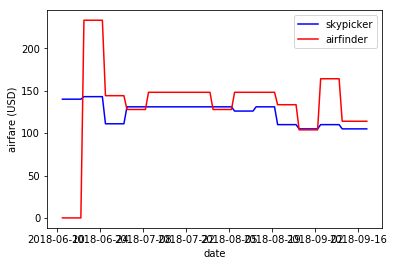

In [10]:
euro_to_usd = 1.18
plt.figure()
plt.clf()
l1,=plt.plot(prices.index,prices['skypicker'],'-b')
l2,=plt.plot(prices.index,prices['airfinder']*euro_to_usd,'-r')
plt.xlabel('date')
plt.ylabel('airfare (USD)')
plt.legend([l1,l2],['skypicker','airfinder'])